In [13]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
mp.rcParams['axes.linewidth'] = 1
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [14]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [15]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
SIR_data = pd.read_csv('../../data/SIR_data.csv.gz')
SIR_data

alpha      beta                                                  I  \
0    0.556824  0.432547  [3.0000e+00,2.5413e+01,6.6242e+01,1.4076e+02,2...   
1    0.917183  0.617733  [3.0000e+00,4.6435e+01,1.2668e+02,1.8865e+02,1...   
2    0.222595  0.684092  [3.0000e+00,2.3207e+02,5.2139e+02,5.1127e+02,4...   
3    0.513685  0.231400  [3.0000e+00,6.2250e+00,8.8920e+00,1.2593e+01,1...   
4    0.533168  0.343659  [3.0000e+00,1.3872e+01,2.8699e+01,5.5722e+01,9...   
..        ...       ...                                                ...   
245  0.018504  0.236397  [3.0000e+00,1.7329e+01,4.0684e+01,9.1622e+01,1...   
246  0.183638  0.371210  [3.0000e+00,3.3838e+01,1.0217e+02,2.4462e+02,4...   
247  0.097239  0.421748  [3.0000e+00,5.7375e+01,2.0121e+02,4.4055e+02,5...   
248  0.790416  0.309533  [3.0000e+00,6.4540e+00,9.3210e+00,1.3244e+01,1...   
249  0.498675  0.419194  [3.0000e+00,2.5851e+01,6.8293e+01,1.4792e+02,2...   

                                                    li  
0    [3.5465e-02,6.0205e-02,5.2629e-02,1.9994e-02,3...  
1    [4.6994e-02,6.1737e-02,5.9416e-02,6.5321e-02,3...  
2    [3.8465e-02,1.4980e-02,4.3391e-02,8.0108e-02,6...  
3    [1.2181e-01,1.2303e-01,6.9494e-02,8.3929e-02,6...  
4    [2.9563e-02,5.4805e-02,2.3345e-02,1.7169e-01,5...  
..                                                 ...  
245  [3.5029e-02,7.6161e-02,9.8830e-02,2.7422e-02,1...  
246  [5.3251e-02,9.8350e-02,3.7443e-02,2.2209e-02,1...  
247  [2.2518e-02,4.6346e-02,2.5197e-02,5.0298e-02,4...  
248  [6.6862e-02,4.2194e-02,5.7831e-02,3.8413e-02,3...  
249  [2.1645e-02,1.3017e-02,1.2058e-01,4.5645e-02,5...  

[250 rows x 4 columns]

In [17]:
print('alpha in [%.2f, %.2f]' % (SIR_data['alpha'].min(), SIR_data['alpha'].max()))
print('beta in [%.2f, %.2f]' % (SIR_data['beta'].min(), SIR_data['beta'].max()))

alpha in [0.00, 1.00]
beta in [0.20, 0.70]


In [18]:
def cdf(lst, x):

    count = sum(1 for num in lst if num <= x)
    return count / len(lst)


def flatten_SIR_data(df):
    """ and add cdf column"""
    alpha_l = []
    beta_l = []
    Infected_l = []
    li_l = []
    true_CDF_l=[]
    for rowind, row in df.iterrows():
        li = eval(row['li'])
        
        for lambda_val in li:
            true_CDF_l.append(cdf(li, lambda_val))
    
    for rowind, row in df.iterrows():
    #     Infected = eval(row['I'])
    #     Infected_l.append(Infected)
        
        li = eval(row['li'])
        li_l.append(li)

        
        alpha_r = np.full_like(li, row['alpha'])
        alpha_l.append(alpha_r)
        
        beta_r = np.full_like(li, row['beta'])
        beta_l.append(beta_r)
        
        
    
    # for arr in [alpha_l, beta_l, Infected_l, li_l]:
    #     arr = np.array(arr).flatten()
    alpha_l = np.array(alpha_l).flatten()
    beta_l = np.array(beta_l).flatten()
    # Infected_l = np.array(Infected_l).flatten()
    li_l = np.array(li_l).flatten()
    true_CDF_l = np.array(true_CDF_l).flatten()
    
    data_flat = pd.DataFrame({
        'alpha':alpha_l,
        'beta': beta_l,
        # 'I' :Infected_l,
        'li':li_l,
        'true_CDF':true_CDF_l 
    })
    
    return data_flat

In [19]:
SIR_data_flat = flatten_SIR_data(SIR_data)
SIR_data_flat

alpha      beta        li  true_CDF
0      0.556824  0.432547  0.035465    0.3400
1      0.556824  0.432547  0.060205    0.6125
2      0.556824  0.432547  0.052629    0.5350
3      0.556824  0.432547  0.019994    0.0725
4      0.556824  0.432547  0.035213    0.3300
...         ...       ...       ...       ...
99995  0.498675  0.419194  0.077266    0.7225
99996  0.498675  0.419194  0.043796    0.4475
99997  0.498675  0.419194  0.014526    0.0250
99998  0.498675  0.419194  0.055118    0.5675
99999  0.498675  0.419194  0.054795    0.5650

[100000 rows x 4 columns]

In [20]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def get_bootstrap(train_x, train_t):
    from copy import deepcopy
    N = len(train_x)
    arr =np.arange(0,N-1)
    select =[]
    for i in range(N):
        integer = np.random.randint(0,N-1)
        select.append(integer)
        
    return deepcopy(train_x[select]), deepcopy(train_t[select])

def getwholedata_delta_SIR():
    """ Get train test split arrays"""
    
    data = SIR_data_flat
        
    train_data, test_data = train_test_split(data, test_size=0.1)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='true_CDF'
    # target='y'
    # source = ['theta','nu','theta_hat','N','M']

    # source = ['theta', 'nu', 'lambda', 'true_CDF']
    source = ['alpha', 'beta', 'li']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.015)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    # train_x, train_t = get_bootstrap(train_x, train_t)
    
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

In [28]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_delta_SIR()
N_Features = train_x.shape[1]

train_t shape =  (90000,) 

train_x shape =  (90000, 3) 



In [29]:
SUBSAMPLE=1000
train_t, train_x, test_t,  test_x, valid_t, valid_x = train_t[:SUBSAMPLE], train_x[:SUBSAMPLE], test_t[:SUBSAMPLE],  test_x[:SUBSAMPLE], valid_t[:SUBSAMPLE], valid_x[:SUBSAMPLE]

In [30]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

from torch.autograd import Variable

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)
    
    
def RMS(v):
    return (torch.mean(v**2)) ** 0.5

def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape

    # inv = torch.where(t !=0, 1/torch.abs(t), 1)
    
    # inv_RMS = torch.where(t !=0, 1/RMS(t), 1)
    
    return  torch.mean(  (f - t)**2)

# Huber loss function
def huber_loss(f, t, x):
    delta=torch.Tensor([1.0])
    huber_mse = 0.5*(f-t)**2
    huber_mae = delta * (torch.abs(t - f) - 0.5 * delta)
    return torch.where(torch.abs(t - f) <= delta, huber_mse, huber_mae)
    
def Huber_loss(f, t, x):
    return torch.nn.functional.huber_loss(f,t, delta=0.7)

def absolute_error(f,t,x):
    return torch.mean(torch.abs(f-t) )

def kl_divergence_loss(q, p, x):
    criterion = torch.nn.KLDivLoss(reduction='batchmean')
    loss = criterion(torch.log(p), q)
    return loss


def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float().to(device)
        t = torch.from_numpy(targets).float().to(device)
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)

In [31]:
class SIRModel(nn.Module):
    """Used for hyperparameter tuning"""

    # inherit from the super class
    def __init__(
        self,
        nfeatures,
        ntargets,
        nlayers,
        hidden_size,
        activation,
    ):
        super().__init__()
        layers = []
        for i in range(nlayers):
            if len(layers) == 0:
                # nlayers is number of hidden layers+1, since there is always an input layer and an output layer
                # INPUT LAYER
                # inital layer has to have size of (input features, output_nodes),
                # its output layer can have any size but it must match the size of the input layer of the next linear layer
                # here we choose its output layer as the hidden size (fully connected)
                # ALPHA DROPOUT
                # layers.append(nn.AlphaDropout(dropout_1))

                layer = nn.Linear(nfeatures, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                # batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                # dropout should have higher values in deeper layers
                # layers.append(nn.Dropout(dropout_1))#Use small dropout for 1st layers & larger dropout for later layers. In both cases, the larger he model the larger the dropout.
                # When model is in training, apply dropout. When using model for inference, dont use dropout

                # ReLU activation
                if activation == "LeakyReLU":
                    layers.append(nn.LeakyReLU(negative_slope=0.3))
                elif activation == "ReLU":
                    layers.append(nn.ReLU())
                elif activation == "PReLU":
                    layers.append(nn.PReLU())
                elif activation == "ReLU6":
                    layers.append(nn.ReLU6())
                elif activation == "ELU":
                    layers.append(nn.ELU())
                elif activation == "SELU":
                    layers.append(nn.SELU())
                elif activation == "CELU":
                    layers.append(nn.CELU())

            else:
                # if this is not the first layer (we dont have layers)
                layer = nn.Linear(hidden_size, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                # layers.append(nn.Dropout(dropout_2))
                # layers.append(nn.BatchNorm1d(hidden_size))

                if activation == "LeakyReLU":
                    layers.append(nn.LeakyReLU(negative_slope=0.3))
                elif activation == "PReLU":
                    layers.append(nn.PReLU())
                elif activation == "ReLU":
                    layers.append(nn.ReLU())
                elif activation == "ReLU6":
                    layers.append(nn.ReLU6())
                elif activation == "ELU":
                    layers.append(nn.ELU())
                elif activation == "SELU":
                    layers.append(nn.SELU())
                elif activation == "CELU":
                    layers.append(nn.CELU())

        # output layer:
        output_layer = nn.Linear(hidden_size, ntargets)
        # torch.nn.init.xavier_uniform_(output_layer.weight)
        layers.append(output_layer)

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid()) or softmax
        # we have defined sequential model using the layers in oulist
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


In [32]:
class HyperTrainer():
    """loss, training and evaluation"""
    def __init__(self, model, optimizer, batch_size, loss_name):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        self.batch_size=batch_size
        self.loss_name = loss_name
        # N_epochs X N_train_examples = N_iterations X batch_size
        # So for 1 epoch, N_iterations = N_train_examples/batch_size
         
        self.n_iterations_tune=train_x.shape[0]//batch_size #int(50) # number of iterations to train on per optuna trial

        #the loss function returns the loss function. It is a static method so it doesn't need self
        # @staticmethod
        # def loss_fun(targets, outputs):
        #   tau = torch.rand(outputs.shape)
        #   return torch.mean(torch.where(targets >= outputs, 
        #                                   tau * (targets - outputs), 
        #                                   (1 - tau)*(outputs - targets)))

        #     This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, 
        #     by combining the operations into one layer

    def train(self, x, t):

        self.model.train()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            self.optimizer.zero_grad()
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            with torch.no_grad():
                inputs=torch.from_numpy(batch_x).float()
                targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            if self.loss_name=="MSE":
                loss = average_quadratic_loss(outputs, targets, inputs)
            elif self.loss_name=="Huber":
                loss = Huber_loss(outputs, targets, inputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()

        return final_loss / self.batch_size

    def evaluate(self, x, t):

        self.model.eval()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            with torch.no_grad():            
                inputs=torch.from_numpy(batch_x).float()
                targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            if self.loss_name=="MSE":
                loss =average_quadratic_loss(outputs, targets, inputs)
            elif self.loss_name=="Huber":
                loss = Huber_loss(outputs, targets, inputs)
            final_loss += loss.item()
        return final_loss / self.batch_size


#########################################################################
# N_epochs X N_train_examples = N_iterations X batch_size

def run_train(params, loss_name, save_model=False):
    """For tuning the parameters"""

    model =  SIRModel(
              nfeatures=train_x.shape[1], 
                ntargets=1,
                nlayers=params["nlayers"], 
                hidden_size=params["hidden_size"],
                activation=params["activation"]
                )
    # print(model)
    

    learning_rate= params["learning_rate"]
    optimizer_name = params["optimizer_name"]
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"]) 
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), 
                            lr=learning_rate, 
                            # momentum = params["momentum"]
                                                    )
    
    trainer=HyperTrainer(model, optimizer, batch_size=params["batch_size"], loss_name=loss_name)
    best_loss = np.inf
    early_stopping_iter=10#stop after 10 iteractions of not improving loss
    early_stopping_coutner=0
    EPOCHS=5
    
    for epoch in range(EPOCHS):
        train_loss = trainer.train(train_x, train_t)
        test_loss = trainer.evaluate(test_x, test_t)

        # # Early stopping logic (if needed)
        # if test_loss < best_loss:
        #     best_loss = test_loss
        #     early_stopping_counter = 0
        # else:
        #     early_stopping_counter += 1
        #     if early_stopping_counter > early_stopping_iter:
        #         break

    return test_loss

In [33]:
def objective_MSE(trial):
    CLUSTER=False
    #cluster has greater memory than my laptop, which allows higher max values in hyperparam. search space
    if CLUSTER:
        nlayers_max,n_hidden_max, batch_size_max=int(24),int(350), int(2e5)
    else:
        nlayers_max,n_hidden_max, batch_size_max=int(6),int(64), int(3e3)

    #hyperparameter search space:
    params = {
          "nlayers": trial.suggest_int("nlayers",1,nlayers_max),      
          "hidden_size": trial.suggest_int("hidden_size", 1, n_hidden_max),
          "optimizer_name" : trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD", "NAdam"]),
          "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2),
          "batch_size": trial.suggest_int("batch_size", 50, batch_size_max),
        "activation" : trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "SELU", "PReLU"])

        }
    STEPS=10
    loss_name="MSE"
    for step in range(STEPS):

        temp_loss = run_train(params,loss_name=loss_name, save_model=False)
        trial.report(temp_loss, step)
        #activate pruning (early stopping if the current step in the trial has unpromising results)
        #instead of doing lots of iterations, do less iterations and more steps in each trial,  
        #such that a trial is terminated if a step yields an unpromising loss.
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return temp_loss


def tune_hyperparameters_MSE(save_best_params,n_trials=10):
    

    sampler=False#use different sampling technique than the defualt one if sampler=True.
    if sampler:
        #choose a different sampling strategy (https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html#optuna.samplers.CmaEsSampler)
        # sampler=optuna.samplers.RandomSampler()
        study=optuna.create_study(direction='minimize',
                                  pruner=optuna.pruners.MedianPruner(), sampler=sampler)
    else:
        #but the default sampler is usually better - no need to change it!
        study=optuna.create_study(direction='minimize',
                                  # pruner=optuna.pruners.HyperbandPruner()
                                 )
    
    study.optimize(objective_MSE, n_trials=n_trials)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    #save best hyperapameters in a pandas dataframe as a .csv
    if save_best_params:
        tuned_dir = 'SIR_models'
        filename=os.path.join(tuned_dir,'best_params_SIR_MSE_loss_%s_trials.csv' % str(int(n_trials)))
        print(f'saving file named: {filename}')
        param_df=pd.DataFrame({
                                'n_layers':best_params["nlayers"], 
                                'hidden_size':best_params["hidden_size"], 
                                'optimizer_name':best_params["optimizer_name"],
                                'learning_rate': best_params["learning_rate"], 
                                'batch_size':best_params["batch_size"],
                                'activation': best_params["activation"]
        },
                                        index=[0]
        )

        param_df.to_csv(filename)   
    return study

In [34]:
NTRIALS = 7
study_MSE= tune_hyperparameters_MSE(save_best_params=True, n_trials=NTRIALS)

[I 2024-10-21 18:17:37,243] A new study created in memory with name: no-name-a9747605-49ae-4818-95e8-a63d38ed1684
[I 2024-10-21 18:17:37,255] Trial 0 finished with value: 0.0 and parameters: {'nlayers': 1, 'hidden_size': 10, 'optimizer_name': 'NAdam', 'learning_rate': 0.0025691451724344522, 'batch_size': 1195, 'activation': 'ReLU'}. Best is trial 0 with value: 0.0.
[I 2024-10-21 18:17:37,450] Trial 1 finished with value: 0.00033558382524698265 and parameters: {'nlayers': 2, 'hidden_size': 40, 'optimizer_name': 'SGD', 'learning_rate': 0.004258508142900627, 'batch_size': 633, 'activation': 'ReLU'}. Best is trial 0 with value: 0.0.
[I 2024-10-21 18:17:37,475] Trial 2 finished with value: 0.0 and parameters: {'nlayers': 6, 'hidden_size': 5, 'optimizer_name': 'SGD', 'learning_rate': 0.0066793647109133466, 'batch_size': 2201, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.0.
[I 2024-10-21 18:17:37,492] Trial 3 finished with value: 0.0 and parameters: {'nlayers': 4, 'hidden_size': 

best model parameters {'nlayers': 1, 'hidden_size': 10, 'optimizer_name': 'NAdam', 'learning_rate': 0.0025691451724344522, 'batch_size': 1195, 'activation': 'ReLU'}
saving file named: SIR_models/best_params_SIR_MSE_loss_7_trials.csv


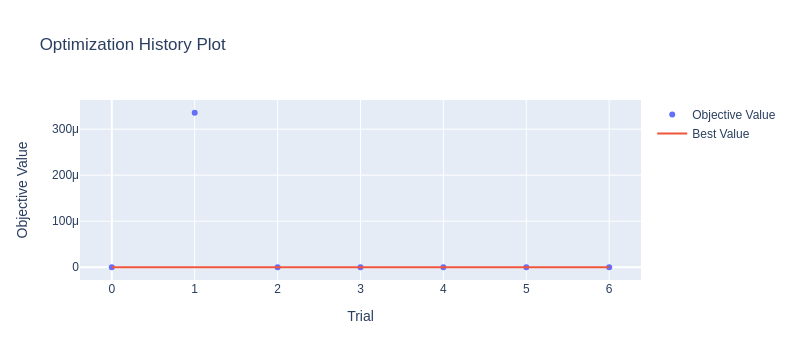

In [35]:
plot_optimization_history(study_MSE)

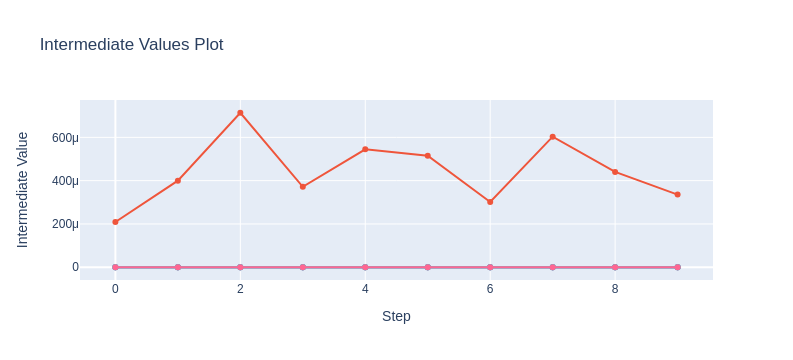

In [36]:
plot_intermediate_values(study_MSE)

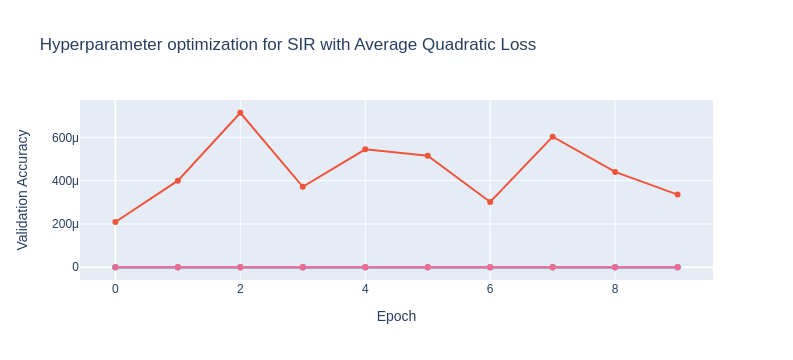

In [37]:
fig = plot_intermediate_values(study_MSE)
fig.update_layout(
    title="Hyperparameter optimization for SIR with Average Quadratic Loss",
    xaxis_title="Epoch",
    yaxis_title="Validation Accuracy",
)

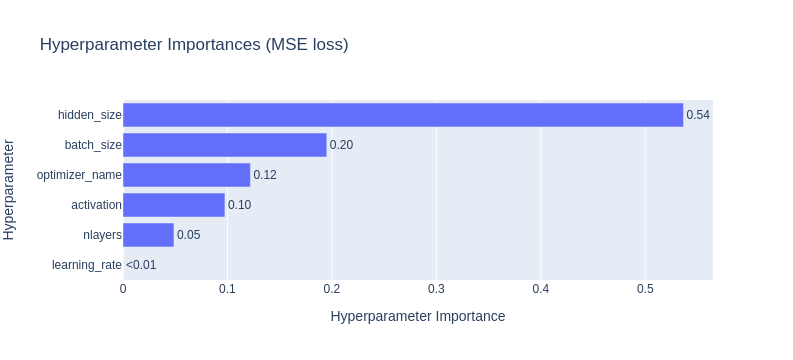

In [40]:
fig = plot_param_importances(study_MSE)
fig.update_layout(
    title = "Hyperparameter Importances (MSE loss)"
)

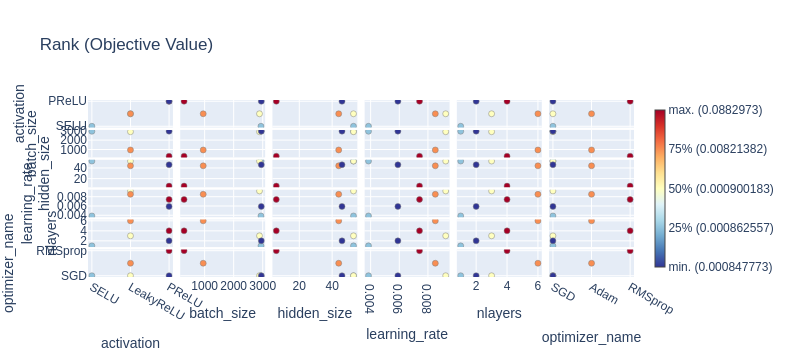

In [160]:
# Visualize parameter relations with scatter plots colored by objective values. See :func:`~optuna.visualization.plot_rank` for the details.
plot_rank(study_MSE)

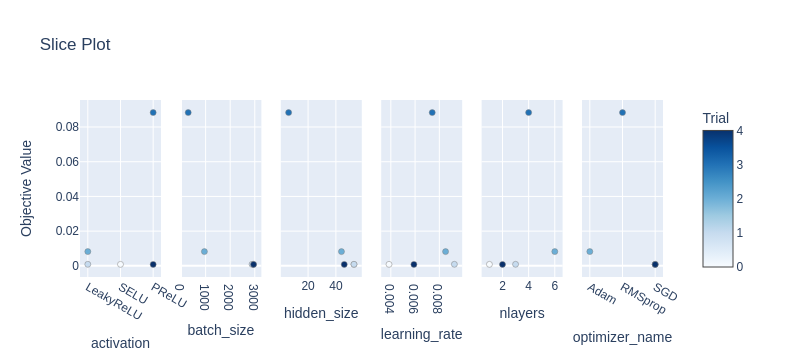

In [161]:
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study_MSE)

## Do the optuna optimization (same thing) but for Huber Loss

In [41]:
def objective_Huber(trial):
    CLUSTER=False
    #cluster has greater memory than my laptop, which allows higher max values in hyperparam. search space
    if CLUSTER:
        nlayers_max,n_hidden_max, batch_size_max=int(24),int(350), int(2e5)
    else:
        nlayers_max,n_hidden_max, batch_size_max=int(6),int(64), int(3e3)

    #hyperparameter search space:
    params = {
          "nlayers": trial.suggest_int("nlayers",1,nlayers_max),      
          "hidden_size": trial.suggest_int("hidden_size", 1, n_hidden_max),
          "optimizer_name" : trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD", "NAdam"]),
          "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2),
          "batch_size": trial.suggest_int("batch_size", 50, batch_size_max),
        "activation" : trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "SELU", "PReLU"])

        }
    STEPS=10
    loss_name="Huber"
    for step in range(STEPS):

        temp_loss = run_train(params,loss_name=loss_name, save_model=False)
        trial.report(temp_loss, step)
        #activate pruning (early stopping if the current step in the trial has unpromising results)
        #instead of doing lots of iterations, do less iterations and more steps in each trial,  
        #such that a trial is terminated if a step yields an unpromising loss.
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return temp_loss


def tune_hyperparameters_Huber(save_best_params,n_trials=10):
    

    sampler=False#use different sampling technique than the defualt one if sampler=True.
    if sampler:
        #choose a different sampling strategy (https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html#optuna.samplers.CmaEsSampler)
        # sampler=optuna.samplers.RandomSampler()
        study=optuna.create_study(direction='minimize',
                                  pruner=optuna.pruners.MedianPruner(), sampler=sampler)
    else:
        #but the default sampler is usually better - no need to change it!
        study=optuna.create_study(direction='minimize',
                                  # pruner=optuna.pruners.HyperbandPruner()
                                 )
    
    study.optimize(objective_Huber, n_trials=n_trials)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    #save best hyperapameters in a pandas dataframe as a .csv
    if save_best_params:
        tuned_dir = 'SIR_models'
        filename=os.path.join(tuned_dir,'best_params_SIR_Huber_loss_%s_trials.csv' % str(int(n_trials)))
        print(f'saving file named: {filename}')
        param_df=pd.DataFrame({
                                'n_layers':best_params["nlayers"], 
                                'hidden_size':best_params["hidden_size"], 
                                'optimizer_name':best_params["optimizer_name"],
                                'learning_rate': best_params["learning_rate"], 
                                'batch_size':best_params["batch_size"],
                                'activation': best_params["activation"]
        },
                                        index=[0]
        )

        param_df.to_csv(filename)   
    return study

In [42]:
study_Huber= tune_hyperparameters_Huber(save_best_params=True, n_trials=NTRIALS)

[I 2024-10-21 18:18:52,826] A new study created in memory with name: no-name-04bcb969-9dc5-4ff0-8f8f-7ecd93fee6a4
[I 2024-10-21 18:18:52,833] Trial 0 finished with value: 0.0 and parameters: {'nlayers': 1, 'hidden_size': 27, 'optimizer_name': 'Adam', 'learning_rate': 0.0001585367906356881, 'batch_size': 2130, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.0.
/tmp/ipykernel_1372987/3689454258.py:42: UserWarning:

Using a target size (torch.Size([592])) that is different to the input size (torch.Size([592, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

[I 2024-10-21 18:18:53,051] Trial 1 finished with value: 7.053277757320855e-05 and parameters: {'nlayers': 6, 'hidden_size': 35, 'optimizer_name': 'NAdam', 'learning_rate': 0.009232784433341405, 'batch_size': 592, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.0.
[I 2024-10-21 18:18:53,062] Trial 2 finished with value: 0.0 and parameters: {'nlayers': 3, 'h

best model parameters {'nlayers': 1, 'hidden_size': 27, 'optimizer_name': 'Adam', 'learning_rate': 0.0001585367906356881, 'batch_size': 2130, 'activation': 'LeakyReLU'}
saving file named: SIR_models/best_params_SIR_Huber_loss_7_trials.csv


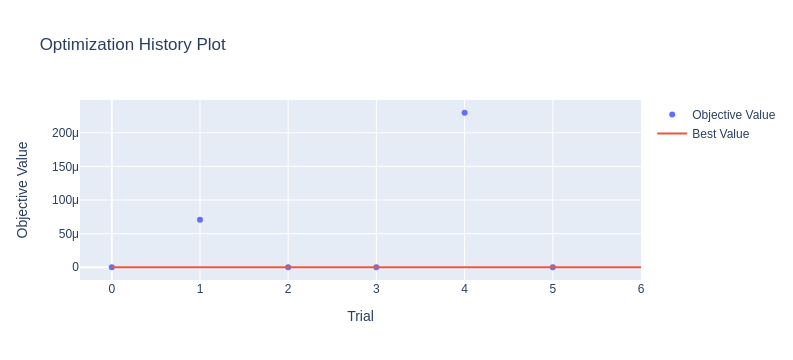

In [43]:
plot_optimization_history(study_Huber)

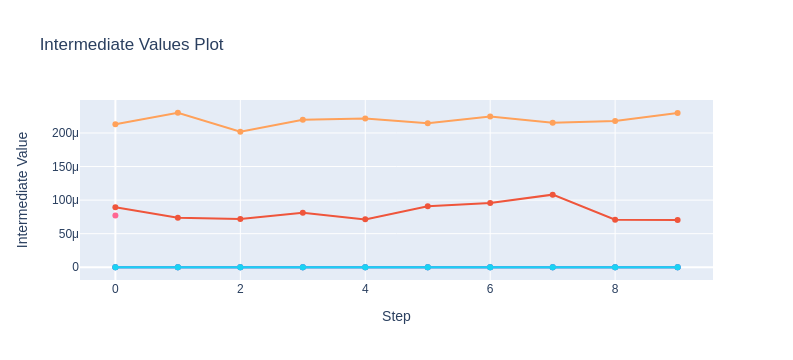

In [44]:
plot_intermediate_values(study_Huber)

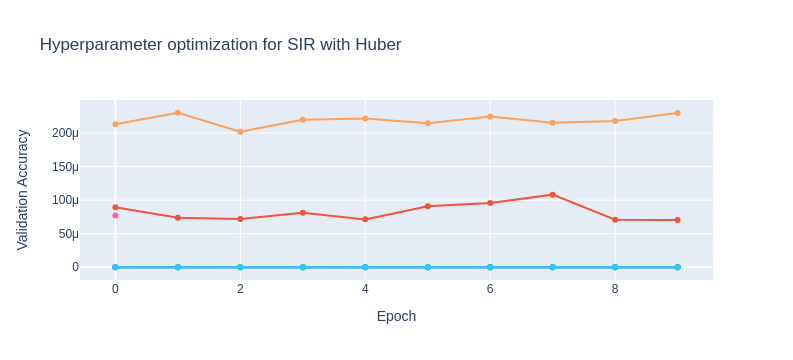

In [45]:
fig = plot_intermediate_values(study_Huber)
fig.update_layout(
    title="Hyperparameter optimization for SIR with Huber",
    xaxis_title="Epoch",
    yaxis_title="Validation Accuracy",
)

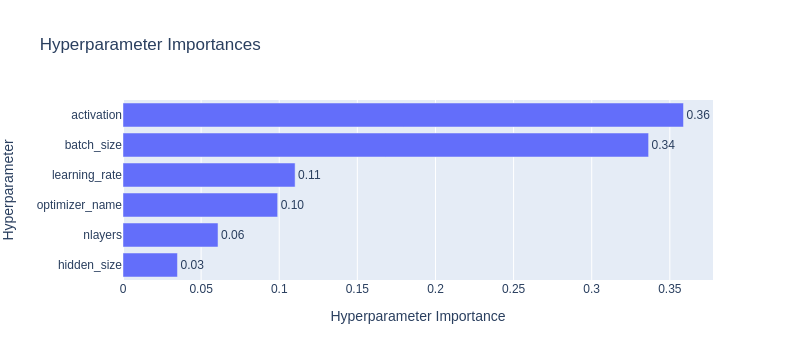

In [46]:
plot_param_importances(study_Huber)

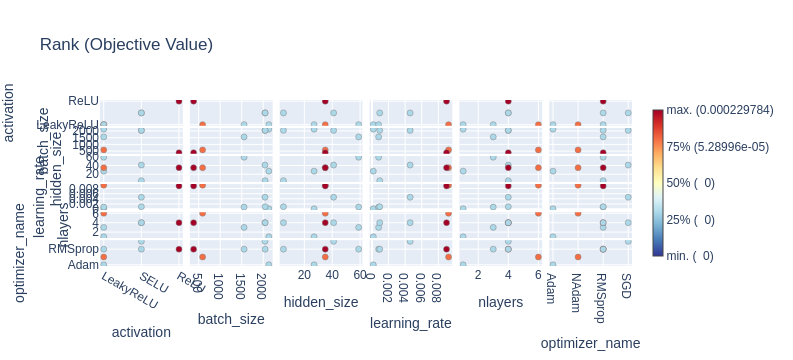

In [47]:
# Visualize parameter relations with scatter plots colored by objective values. See :func:`~optuna.visualization.plot_rank` for the details.
plot_rank(study_Huber)

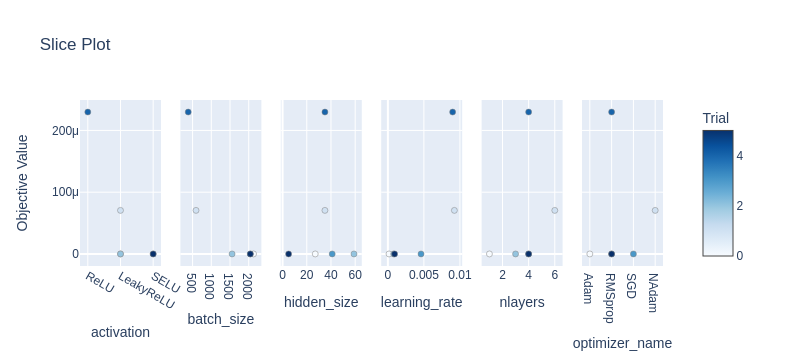

In [48]:
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study_Huber)

## Train new model with optimized hyperparameters for long iterations (MSE loss)

In [49]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a dictionary of dictionaries"""
    models_path = os.path.join(os.getcwd(), 'SIR_models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with the string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    # print(model)

In [50]:
class SaveModelCheckpoint:
    """Continuous model-checkpointing class. Updates the latest checkpoint of an object based o validation loss each time its called. 
    """
    def __init__(self, best_valid_loss=np.inf):
        """Initiate an instance of the class based on filename and best_valid_loss/

        Args:
            best_valid_loss (float, optional): Best possible validation loss of a checkpoint object. Defaults to np.inf.
        """
        self.best_valid_loss = best_valid_loss

    def __call__(self, model, current_valid_loss, PARAMS, pth_string):
        """When an object of the calss is called, its validation loss gets updated and the model based 
        on the latest validation loss is saved.

        Args:
            model: utils.RegularizedRegressionModel object.
            current_valid_loss (float): current (latest) validation loss of this model during the training process.
            filename_model (str): filename in which the latest model will be saved. Can be a relative or local path. 
        """
        if current_valid_loss < self.best_valid_loss:
            # update the best loss
            self.best_valid_loss = current_valid_loss
            # filename_model='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
            # filename_model = "Trained_IQNx4_%s_TUNED_2lin_with_noise.dict" % target

            # note that n_iterations is the total n_iterations, we dont want to save a million files for each iteration
            save_model(model, PARAMS, pth_string)
            print(
                f"\nCurrent valid loss: {current_valid_loss};  saved better model in models/{pth_string}"
            )
            # save using .pth object which if a dictionary of dicionaries, so that I can have PARAMS saved in the same file


In [56]:
def initiate_optimized_model(ntrials, loss_name):
    tuned_dir = 'SIR_models'
    if loss_name=="MSE":
        best_params_filename=os.path.join(tuned_dir,'best_params_SIR_MSE_loss_%s_trials.csv' % str(int(ntrials)))
    elif loss_name=="Huber":
        best_params_filename=os.path.join(tuned_dir,'best_params_SIR_Huber_loss_%s_trials.csv' % str(int(ntrials)))

    BEST_PARAMS = pd.read_csv(best_params_filename)
    print(BEST_PARAMS)

    n_layers = int(BEST_PARAMS["n_layers"]) 
    hidden_size = int(BEST_PARAMS["hidden_size"])

    optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    learning_rate =  float(BEST_PARAMS["learning_rate"])
    batch_size = int(BEST_PARAMS["batch_size"])
    activation = BEST_PARAMS["activation"].to_string().split()[1]

    optimized_model = SIRModel(
                  nfeatures=train_x.shape[1], 
                    ntargets=1,
                    nlayers=n_layers, 
                    hidden_size=hidden_size,
                    activation=activation
                    )
    print(optimized_model)
    return optimized_model

In [57]:
optimized_model_untrained_MSE = initiate_optimized_model(ntrials=NTRIALS, loss_name="MSE")

   Unnamed: 0  n_layers  hidden_size optimizer_name  learning_rate  \
0           0         1           10          NAdam       0.002569   

   batch_size activation  
0        1195       ReLU  
SIRModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [65]:
def train_SIR(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, PARAMS, pth_string):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    model = model.to(device)
    

    train_t, train_x, test_t,  test_x, _, _ = getwholedata_delta_SIR()

    model_checkpoint = SaveModelCheckpoint()
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float().to(device)
            t = torch.from_numpy(batch_t).float().to(device)    


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            model_checkpoint(model=model, current_valid_loss=acc_v, PARAMS=PARAMS, pth_string=pth_string)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [66]:
tuned_dir = 'SIR_models'
best_params_filename_MSE=os.path.join(tuned_dir,'best_params_SIR_MSE_loss_%s_trials.csv' % str(int(NTRIALS)))
print(best_params_filename_MSE)
BEST_PARAMS_MSE = pd.read_csv(best_params_filename_MSE)
BEST_PARAMS_MSE

SIR_models/best_params_SIR_MSE_loss_7_trials.csv


Unnamed: 0  n_layers  hidden_size optimizer_name  learning_rate  \
0           0         1           10          NAdam       0.002569   

   batch_size activation  
0        1195       ReLU

In [71]:
SIR_Model_MSE_Tuned_PARAMS = {
    "n_layers": int(BEST_PARAMS_MSE["n_layers"]) ,
"hidden_size":  int(BEST_PARAMS_MSE["hidden_size"]),
# "dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": BEST_PARAMS_MSE["activation"].to_string().split()[1],
'optimizer_name':BEST_PARAMS_MSE["optimizer_name"].to_string().split()[1],
'starting_learning_rate':float(BEST_PARAMS_MSE["learning_rate"]),
# 'momentum':float(0.9),
'batch_size':int(BEST_PARAMS_MSE["batch_size"]),
'n_iterations': int(3e4),
'traces_step':int(1000),
# 'L2':float(0.1),
'pth_string':'SIR_MSE_Tuned_Ntrials_%s.pth' %  str(int(NTRIALS))
}
SIR_Model_MSE_Tuned_PARAMS

{'n_layers': 1,
 'hidden_size': 10,
 'NFEATURES': 3,
 'activation': 'ReLU',
 'optimizer_name': 'NAdam',
 'starting_learning_rate': 0.0025691451724344,
 'batch_size': 1195,
 'n_iterations': 30000,
 'traces_step': 1000,
 'pth_string': 'SIR_MSE_Tuned_Ntrials_7.pth'}

In [72]:
optimizer_name=SIR_Model_MSE_Tuned_PARAMS["optimizer_name"]
optimizer_SIR = getattr(torch.optim, str(optimizer_name))(optimized_model_untrained_MSE.parameters(), 
                                                           lr=SIR_Model_MSE_Tuned_PARAMS["starting_learning_rate"])

traces_tuned_SIR_MSE = ([], [], [], [])
traces_tuned_SIR_MSE = train_SIR(model=optimized_model_untrained_MSE,
                             optimizer = optimizer_SIR,
                             avloss=average_quadratic_loss,
                             batch_size=SIR_Model_MSE_Tuned_PARAMS["batch_size"],
                             n_iterations = SIR_Model_MSE_Tuned_PARAMS["n_iterations"],
                             traces = traces_tuned_SIR_MSE,
                             step=SIR_Model_MSE_Tuned_PARAMS["traces_step"],
                             window=200,
                             PARAMS=SIR_Model_MSE_Tuned_PARAMS,
                             pth_string=SIR_Model_MSE_Tuned_PARAMS["pth_string"]
                             
                            )   

train_t shape =  (90000,) 

train_x shape =  (90000, 3) 

Iteration vs average loss
 iteration	 train-set	 valid-set
saving model with the string : SIR_MSE_Tuned_Ntrials_7.pth


Current valid loss: 0.004664249252527952;  saved better model in models/SIR_MSE_Tuned_Ntrials_7.pth
         0	  0.004767	  0.004664
saving model with the string : SIR_MSE_Tuned_Ntrials_7.pth


Current valid loss: 0.00410075718536973;  saved better model in models/SIR_MSE_Tuned_Ntrials_7.pth
      1000	  0.004198	  0.004101	  0.004101saving model with the string : SIR_MSE_Tuned_Ntrials_7.pth


Current valid loss: 0.003811874659731984;  saved better model in models/SIR_MSE_Tuned_Ntrials_7.pth
      2000	  0.003916	  0.003812	  0.003812saving model with the string : SIR_MSE_Tuned_Ntrials_7.pth


Current valid loss: 0.0034356333781033754;  saved better model in models/SIR_MSE_Tuned_Ntrials_7.pth
      3000	  0.003565	  0.003436	  0.003436saving model with the string : SIR_MSE_Tuned_Ntrials_7.pth


Current valid lo

## Train new model with optimized hyperparameters for long iterations (Huber loss)

In [73]:
optimized_model_untrained_Huber = initiate_optimized_model(ntrials=NTRIALS, loss_name="Huber")

   Unnamed: 0  n_layers  hidden_size optimizer_name  learning_rate  \
0           0         1           27           Adam       0.000159   

   batch_size activation  
0        2130  LeakyReLU  
SIRModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=27, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Linear(in_features=27, out_features=1, bias=True)
  )
)


In [74]:
tuned_dir = 'SIR_models'
best_params_filename_Huber=os.path.join(tuned_dir,'best_params_SIR_Huber_loss_%s_trials.csv' % str(int(NTRIALS)))
print(best_params_filename_Huber)
BEST_PARAMS_HUBER = pd.read_csv(best_params_filename_Huber)
BEST_PARAMS_HUBER

SIR_models/best_params_SIR_Huber_loss_7_trials.csv


Unnamed: 0  n_layers  hidden_size optimizer_name  learning_rate  \
0           0         1           27           Adam       0.000159   

   batch_size activation  
0        2130  LeakyReLU

In [75]:
SIR_Model_HUBER_Tuned_PARAMS = {
"n_layers": int(BEST_PARAMS_HUBER["n_layers"]) ,
"hidden_size":  int(BEST_PARAMS_HUBER["hidden_size"]),
# "dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": BEST_PARAMS_HUBER["activation"].to_string().split()[1],
'optimizer_name':BEST_PARAMS_HUBER["optimizer_name"].to_string().split()[1],
'starting_learning_rate':float(BEST_PARAMS_HUBER["learning_rate"]),
# 'momentum':float(0.9),
'batch_size':int(BEST_PARAMS_HUBER["batch_size"]),
'n_iterations': int(3e4),
'traces_step':int(1000),
# 'L2':float(0.1),
'pth_string':'SIR_HUBER_Tuned_Ntrials_%s.pth' %  str(int(NTRIALS))
}
SIR_Model_HUBER_Tuned_PARAMS

{'n_layers': 1,
 'hidden_size': 27,
 'NFEATURES': 3,
 'activation': 'LeakyReLU',
 'optimizer_name': 'Adam',
 'starting_learning_rate': 0.0001585367906356,
 'batch_size': 2130,
 'n_iterations': 30000,
 'traces_step': 1000,
 'pth_string': 'SIR_HUBER_Tuned_Ntrials_7.pth'}

In [76]:
optimizer_name=SIR_Model_HUBER_Tuned_PARAMS["optimizer_name"]
optimizer_SIR = getattr(torch.optim, str(optimizer_name))(optimized_model_untrained_Huber.parameters(), 
                                                           lr=SIR_Model_HUBER_Tuned_PARAMS["starting_learning_rate"])

traces_tuned_SIR_HUBER = ([], [], [], [])
traces_tuned_SIR_HUBER = train_SIR(model=optimized_model_untrained_Huber,
                             optimizer = optimizer_SIR,
                             avloss=Huber_loss,
                             batch_size=SIR_Model_HUBER_Tuned_PARAMS["batch_size"],
                             n_iterations = SIR_Model_HUBER_Tuned_PARAMS["n_iterations"],
                             traces = traces_tuned_SIR_HUBER,
                             step=SIR_Model_HUBER_Tuned_PARAMS["traces_step"],
                             window=200,
                             PARAMS=SIR_Model_HUBER_Tuned_PARAMS,
                             pth_string=SIR_Model_HUBER_Tuned_PARAMS["pth_string"]
                             
                            )   

train_t shape =  (90000,) 

train_x shape =  (90000, 3) 

Iteration vs average loss
 iteration	 train-set	 valid-set
saving model with the string : SIR_HUBER_Tuned_Ntrials_7.pth


Current valid loss: 0.08210808038711548;  saved better model in models/SIR_HUBER_Tuned_Ntrials_7.pth
         0	  0.082567	  0.082108
saving model with the string : SIR_HUBER_Tuned_Ntrials_7.pth


Current valid loss: 0.037809327244758606;  saved better model in models/SIR_HUBER_Tuned_Ntrials_7.pth
      1000	  0.037312	  0.037809	  0.037809saving model with the string : SIR_HUBER_Tuned_Ntrials_7.pth


Current valid loss: 0.03057769685983658;  saved better model in models/SIR_HUBER_Tuned_Ntrials_7.pth
      2000	  0.030068	  0.030578	  0.030578saving model with the string : SIR_HUBER_Tuned_Ntrials_7.pth


Current valid loss: 0.020606933161616325;  saved better model in models/SIR_HUBER_Tuned_Ntrials_7.pth
      3000	  0.020119	  0.020607	  0.020607saving model with the string : SIR_HUBER_Tuned_Ntrials_7.pth




In [96]:
def plot_average_loss(traces_MSE, traces_Huber, ftsize=18,save_loss_plots=False):
    
    xx_MSE, yy_t_MSE, yy_v_MSE, yy_v_avg_MSE = traces_MSE
    xx_Huber, yy_t_Huber, yy_v_Huber, yy_v_avg_Huber = traces_Huber
    
    fig, ax = plt.subplots(1,2, figsize=(16,9))

    
    ax[0].plot(xx_MSE, yy_t_MSE, 'b', lw=2, label='Training (MSE)')
    ax[0].plot(xx_Huber, yy_t_Huber, 'b', lw=2, label='Training (Huber)')
    

    ax[1].plot(xx_MSE, yy_v_MSE, 'r', lw=2, label='Validation (MSE)')
    ax[1].plot(xx_Huber, yy_v_Huber, 'r', lw=2, label='Validation (Huber)')
    
    for i in range(2):
        ax[i].set_xlabel('Iterations', fontsize=ftsize)
        ax[i].set_ylabel('average loss', fontsize=ftsize)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].grid(True, which="both", linestyle='-')
        ax[i].legend(loc='upper right')
    if save_loss_plots:
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    # if show_loss_plots:
    plt.show()


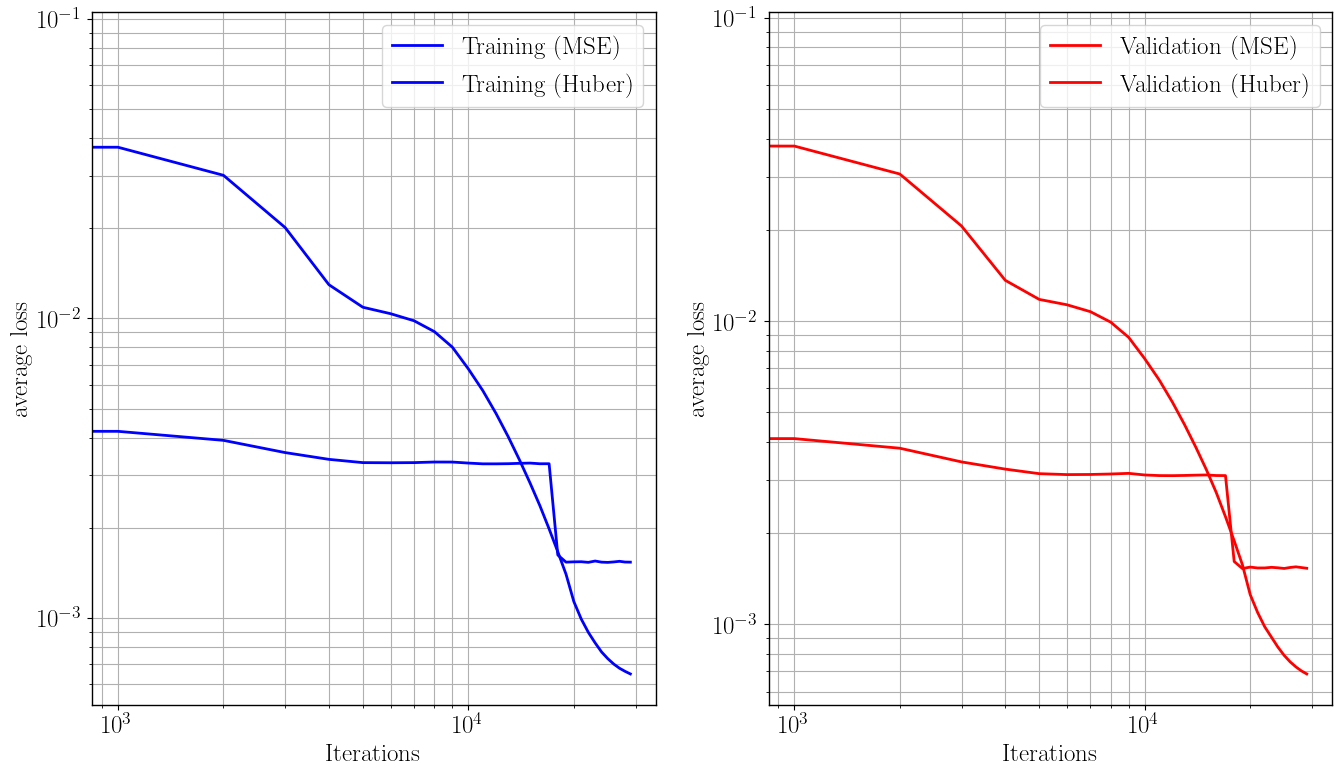

In [97]:
plot_average_loss(traces_MSE=traces_tuned_SIR_MSE, traces_Huber=traces_tuned_SIR_HUBER, ftsize=18,save_loss_plots=False)

## Inference - Evaluate Tuned model

In [142]:
def load_tuned_model(PARAMS, pth_string):
    models_path = os.path.join(os.getcwd(), 'SIR_models')
    PATH=os.path.join(models_path, pth_string)
    model = SIRModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        activation = PARAMS["activation"]
    )
    checkpoint = torch.load(PATH)
    # print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with the string : {pth_string}\n')    
    print(model)
    
    return model

In [143]:
SIR_Tuned_Model_MSE = load_tuned_model(SIR_Model_AQL_Tuned_PARAMS, 
                                 SIR_Model_AQL_Tuned_PARAMS['pth_string'])

loading model with the string : SIR_AQL_Tuned_Ntrials_7.pth

SIRModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=62, bias=True)
    (1): ReLU()
    (2): Linear(in_features=62, out_features=62, bias=True)
    (3): ReLU()
    (4): Linear(in_features=62, out_features=62, bias=True)
    (5): ReLU()
    (6): Linear(in_features=62, out_features=62, bias=True)
    (7): ReLU()
    (8): Linear(in_features=62, out_features=62, bias=True)
    (9): ReLU()
    (10): Linear(in_features=62, out_features=62, bias=True)
    (11): ReLU()
    (12): Linear(in_features=62, out_features=1, bias=True)
  )
)


In [144]:
from genutil import generate, observe, Fsolve, SIRdata

def test_statistic(i, I):
    a = [(d-f)**2/f for d, f in zip(i, I)]
    return np.sqrt(np.array(a).mean()) / SIRdata.scale

def generate_eval_data(alpha,beta, K=500):

    apply_filter = False

    # solve ODEs for current parameter point
    soln = Fsolve(alpha, beta, SIRdata)
    I    = soln.y[1]

    # reduce number of significant figures
    I = [float(int(1000*x))/1000 for x in I]
    # print(I)

    # simulate K epidemics and compute the
    # associated test statistics
    params = (alpha, beta)
    l = []
    counts = []
    for k in range(K):

        # generate data for one epidemic (defined as a sequence of 4-tuples: [t, s, i, r])
        # t: time of event
        # s: number of suceptible individuals at time t
        # i: number of affected individuals at time t
        # r: number of removed individuals at time t
        states = generate(params, SIRdata)

        # observe epidemics at specified observations times T
        obs = observe(SIRdata.T, states)
        i = [x for s,x,r in obs] # get infected counts

        if apply_filter:
            try:
                if i.index(0) < 3:
                    continue
            except:
                pass

        l.append( test_statistic(i, I) )
        
    true_CDF_l=[]    
    for lambda_val in l:
        true_CDF_l.append(cdf(l, lambda_val))
    l = np.array(l)
    alpha_l = np.full_like(l,alpha)
    beta_l = np.full_like(l,beta)
    
    eval_df = pd.DataFrame({'alpha':alpha_l,
                            'beta':beta_l,
                            'li': l,
                            'true_CDF': true_CDF_l
                           })
    eval_df = eval_df.sort_values(by='li')
    
    eval_array = eval_df[['alpha','beta','li']].to_numpy()
    return eval_df, eval_array

In [145]:
ALPHA=0.6
BETA=0.4
eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=ALPHA,beta=BETA, K=300)
eval_df_single_point

alpha  beta        li  true_CDF
244    0.6   0.4  0.008760  0.003333
135    0.6   0.4  0.012628  0.006667
3      0.6   0.4  0.013309  0.010000
123    0.6   0.4  0.014978  0.013333
29     0.6   0.4  0.015216  0.016667
..     ...   ...       ...       ...
259    0.6   0.4  0.183874  0.993333
6      0.6   0.4  0.183874  0.993333
299    0.6   0.4  0.183874  0.993333
103    0.6   0.4  0.191129  0.996667
147    0.6   0.4  0.220888  1.000000

[300 rows x 4 columns]

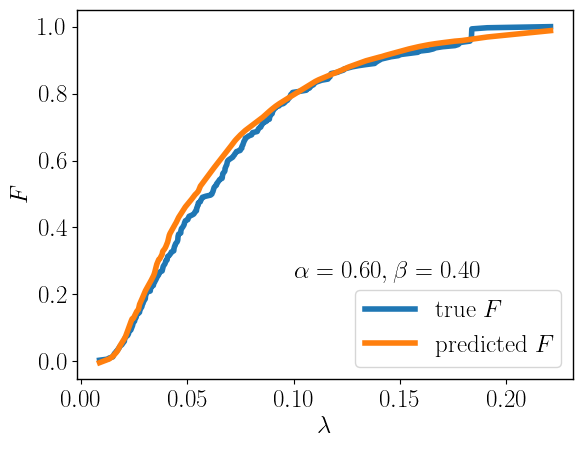

In [146]:
eval_tensor_single_point = torch.Tensor(eval_array_single_point)
CDF_hat = SIR_Tuned_Model_AQL(eval_tensor_single_point).view(-1).detach().numpy()
lambda_ = eval_df_single_point['li']
true_CDF = eval_df_single_point['true_CDF']

# xmin, xmax = lambda_.min(), lambda_.max()
# ymin, ymax = true_CDF.min(), true_CDF.max()
plt.text(0.1, 0.25, r'$\alpha = %.2f, \beta = %.2f$' % (ALPHA,BETA))
plt.plot(lambda_, true_CDF, label=r'true $F$', linewidth=4)
plt.plot(lambda_, CDF_hat, label = r'predicted $F$',linewidth=4)
plt.ylabel(r'$F$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()

In [147]:
def plot_CDF_agreement(nrows, ncols, model, title):
    fig, ax = plt.subplots(nrows,ncols, figsize=(10,10))
    ax = ax.ravel()
    # alpha_beta_l = [(alpha, beta) for alpha in np.random.uniform(0,1, nrows) for beta in np.random.uniform(0.2,0.7, ncols)]
    N = nrows * ncols
    alpha_l = [0.22, 0.28, 0.83, 0.87]
    beta_l = [0.43, 0.47, 0.59, 0.51]
    # alpha_l = np.random.uniform(0.22,0.89, N)
    # beta_l = np.random.uniform(0.32,0.59, N)
    
    for ind, (alpha, beta) in enumerate(zip(alpha_l, beta_l)):
        eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=alpha,beta=beta, K=300)
        eval_tensor_single_point = torch.Tensor(eval_array_single_point)
        CDF_hat = model(eval_tensor_single_point).view(-1).detach().numpy()
        lambda_ = eval_df_single_point['li'].to_numpy().flatten()
        true_CDF = eval_df_single_point['true_CDF'].to_numpy().flatten()

        xmin, xmax = lambda_.min(), lambda_.max()
        ymin, ymax = true_CDF.min(), true_CDF.max()
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4* xwid
        ypos = ymin + 6* ywid
        ax[ind].text(xpos, ypos, r'$\alpha = %.2f, \beta = %.2f$' % (alpha,beta), fontsize=18)
        
        # ax[ind].set_xlim((0,0.26))
        ax[ind].plot(lambda_, true_CDF, label=r'Empirical $F$', linewidth=3, color='darkblue',linestyle='--')
        ax[ind].plot(lambda_, CDF_hat, label = r'$\hat{F}$',linewidth=3,  color='red')
        
        
        ########################################CONFORMAL BAND
        Ncal = len(true_CDF)
        CL=0.683
        alpha_freq = np.ceil((Ncal+1)*(CL))/Ncal
        scores = np.abs(true_CDF-CDF_hat)
        # print(scores.mean(), scores.std())

        qhat = np.quantile(scores, alpha_freq)
        lower_bound = np.array(CDF_hat-qhat)
        upper_bound = np.array(CDF_hat+qhat)
        ax[ind].fill_between(lambda_, y1=lower_bound, 
                         y2=upper_bound, color='k', 
                         alpha=0.25, label = 'Conformal 0.68\% CI')


        ax[ind].set_ylabel(r'$F$',fontsize=20)
        ax[ind].set_xlabel(r'$\lambda$',fontsize=20)
        ax[ind].grid(True, which="both", linestyle='-')
        ax[ind].legend()
    # fig.suptitle(title, fontsize=25)
    plt.tight_layout()
    plt.savefig('../../images/SIR_Empirical_CDF_CDF_TUNED_NTRIALS_%s.pdf' % str(NTRIALS))
    plt.show()

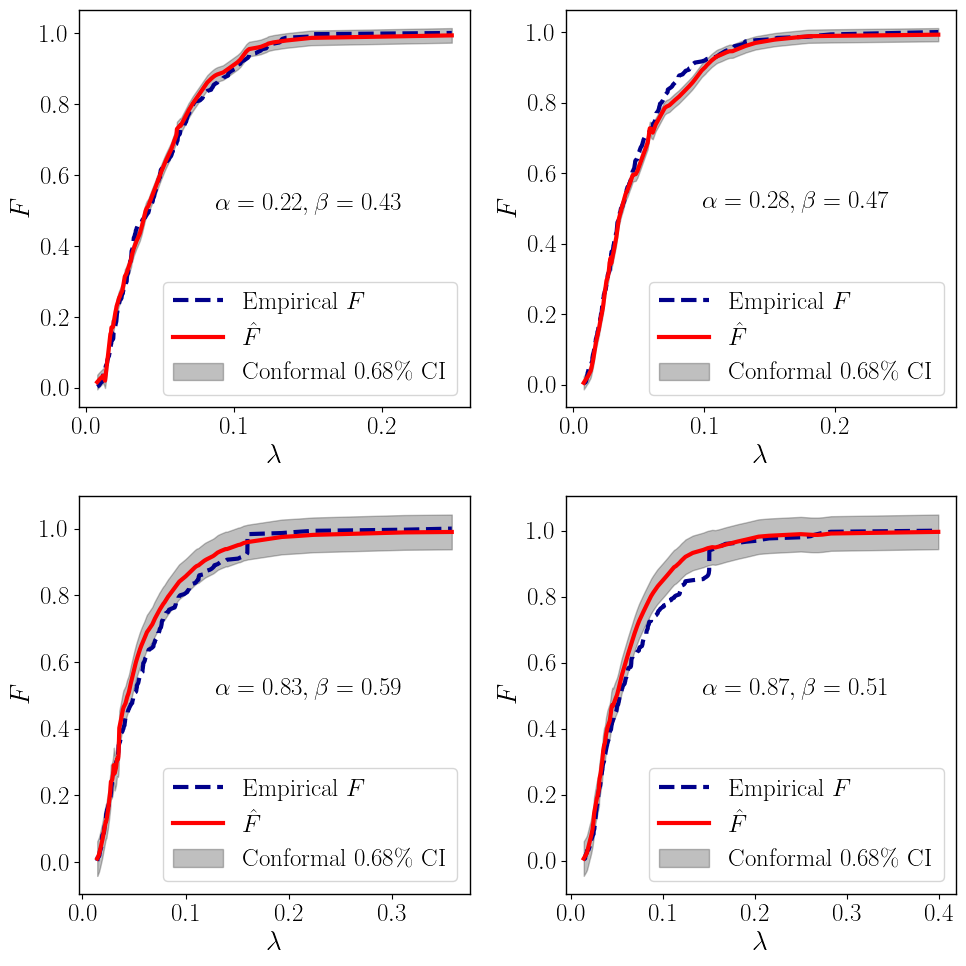

In [148]:
plot_CDF_agreement(nrows=2, ncols=2, 
                   model=SIR_Tuned_Model_AQL, title='MLP with AQL')

## Examine pdfs

In [149]:
class TrainedModel:
    def __init__(self, model):
        self.model = model

    def __cdf(self, x):
        # convert to a tensor and compute
 
        X = torch.Tensor(x)#.transpose(1, 0)
            
        X.requires_grad_(True)
        
        self.model.eval() 
        
        return self.model(X), X 
        
    def cdf(self, x): 
        F, _ = self.__cdf(x)
        
        Y = F.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

        
        Y = F.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y
    
    def numerical_deriv(self,x):
        h=1E-3
        F_h = self.cdf(x+h)
        F = self.cdf(x)
        deriv = (F_h-F)/h
        return deriv
        

    def pdf(self, x):
        F, X = self.__cdf(x)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                               grad_outputs=torch.ones_like(F),
                               #allow_unused=True, 
                               #retain_graph=True, 
                               create_graph=True)[0]
    
        # Y = dFdX.view(-1).detach().numpy()
        Y = dFdX.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y.T[-1]  


In [150]:
ALPHA=0.6
BETA=0.4
eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=ALPHA,beta=BETA, K=200)
eval_df_single_point

alpha  beta        li  true_CDF
177    0.6   0.4  0.012963     0.005
187    0.6   0.4  0.013141     0.010
61     0.6   0.4  0.013387     0.015
130    0.6   0.4  0.014311     0.020
150    0.6   0.4  0.015956     0.025
..     ...   ...       ...       ...
180    0.6   0.4  0.201743     0.980
121    0.6   0.4  0.209483     0.985
57     0.6   0.4  0.220982     0.990
105    0.6   0.4  0.228394     0.995
89     0.6   0.4  0.256129     1.000

[200 rows x 4 columns]

In [151]:
def coarse_grain_lambda(lambda_, alpha, beta, xbins=25, xmin=0, xmax=0.3):
    Y, edges = np.histogram(lambda_, bins=xbins, range=(xmin, xmax), density=True)
    h = edges[1]-edges[0]# bin width
    # Y = np.cumsum(Y) * h# are (CDF_)
    x = (edges[1:]+edges[:-1])/2#bin centers
    X = np.empty((len(x), 3))
    X[:,0] = np.ones_like(alpha)*alpha
    X[:,1] = np.ones_like(beta)*beta
    X[:,2] = np.linspace(x[0], x[-1],len(x))
    return Y, X, x

In [152]:
def plot_PDFs(nrows, ncols, model, title):
    fig, ax = plt.subplots(nrows,ncols, figsize=(20,20))
    ax = ax.ravel()
    BINS=20
    # alpha_beta_l = [(alpha, beta) for alpha in np.random.uniform(0,1, nrows) for beta in np.random.uniform(0.2,0.7, ncols)]
    N = nrows * ncols
    # alpha_l = np.random.uniform(0.22,0.89, N)
    # beta_l = np.random.uniform(0.32,0.59, N)
    alpha_l = [0.22, 0.28, 0.83, 0.87]
    beta_l = [0.43, 0.47, 0.59, 0.51]
    XMIN, XMAX = 0, 0.2
        
    for ind, (alpha, beta) in enumerate(zip(alpha_l, beta_l)):
        eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=alpha,beta=beta, 
                                                                           K=1000)
        eval_tensor_single_point = torch.Tensor(eval_array_single_point)
        tmodel = TrainedModel(model)
        lambda_ = eval_df_single_point['li']
        
        PDF_hat = tmodel.pdf(eval_array_single_point)
        
        xmin, xmax = lambda_.min(), lambda_.max()
        ymin, ymax = PDF_hat.min(), PDF_hat.max()
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4* xwid
        ypos = ymin + 4* ywid
        ax[ind].set_xlim(XMIN,XMAX)
        ax[ind].set_ylim(0,30)
        
        
        
        ax[ind].hist(lambda_, bins=BINS, density=True, histtype='stepfilled', 
                     edgecolor='black', color = 'powderblue', 
                     range=(XMIN,XMAX)
                    )
        


        
        
        
        empirical_PDF, coarse_grained_X, centers =  coarse_grain_lambda(lambda_, alpha, beta, 
                                                                        xbins=BINS, xmin=XMIN, xmax=XMAX)

        
        PDF_hat_coarse_grained = tmodel.pdf(coarse_grained_X)
        
        ax[ind].plot(centers, PDF_hat_coarse_grained, label = r'$\hat{f} =\partial \hat{F} / \partial \lambda$',
                     linewidth=3, color='red')



        

        Ncal = len(empirical_PDF)
        CL=0.683

        alpha_freq = np.ceil((Ncal+1)*(CL))/Ncal

        scores = np.abs(empirical_PDF-PDF_hat_coarse_grained)
        # print(scores.mean(), scores.std())

        qhat = np.quantile(scores, alpha_freq)


        lower_bound = np.array(PDF_hat_coarse_grained-qhat)
        upper_bound = np.array(PDF_hat_coarse_grained+qhat)

        ax[ind].fill_between(centers, y1=lower_bound, 
            y2=upper_bound, 
            color='k', 
            alpha=0.25, label = 'conformal 0.68\% CI')



        xpos = 0.1
        ypos=12
        ax[ind].text(xpos, ypos, 
                     r'$\alpha = %.2f, \beta = %.2f$' % (alpha,beta), 
                     fontsize=35)
        ax[ind].set_ylabel(r'$f$', fontsize=35)
        ax[ind].set_xlabel(r'$\lambda$',fontsize=35)
        ax[ind].legend(fontsize=35)
        ax[ind].grid(True, which="both", linestyle='-')
        ax[ind].tick_params(axis="x", labelsize=35)
        ax[ind].tick_params(axis="y", labelsize=35)
        
    # fig.suptitle(title)
    plt.tight_layout()
    plt.savefig('../../images/SIR_Empirical_CDF_PDF_TUNED_NTRIALS_%s.pdf' % NTRIALS)
    plt.show()

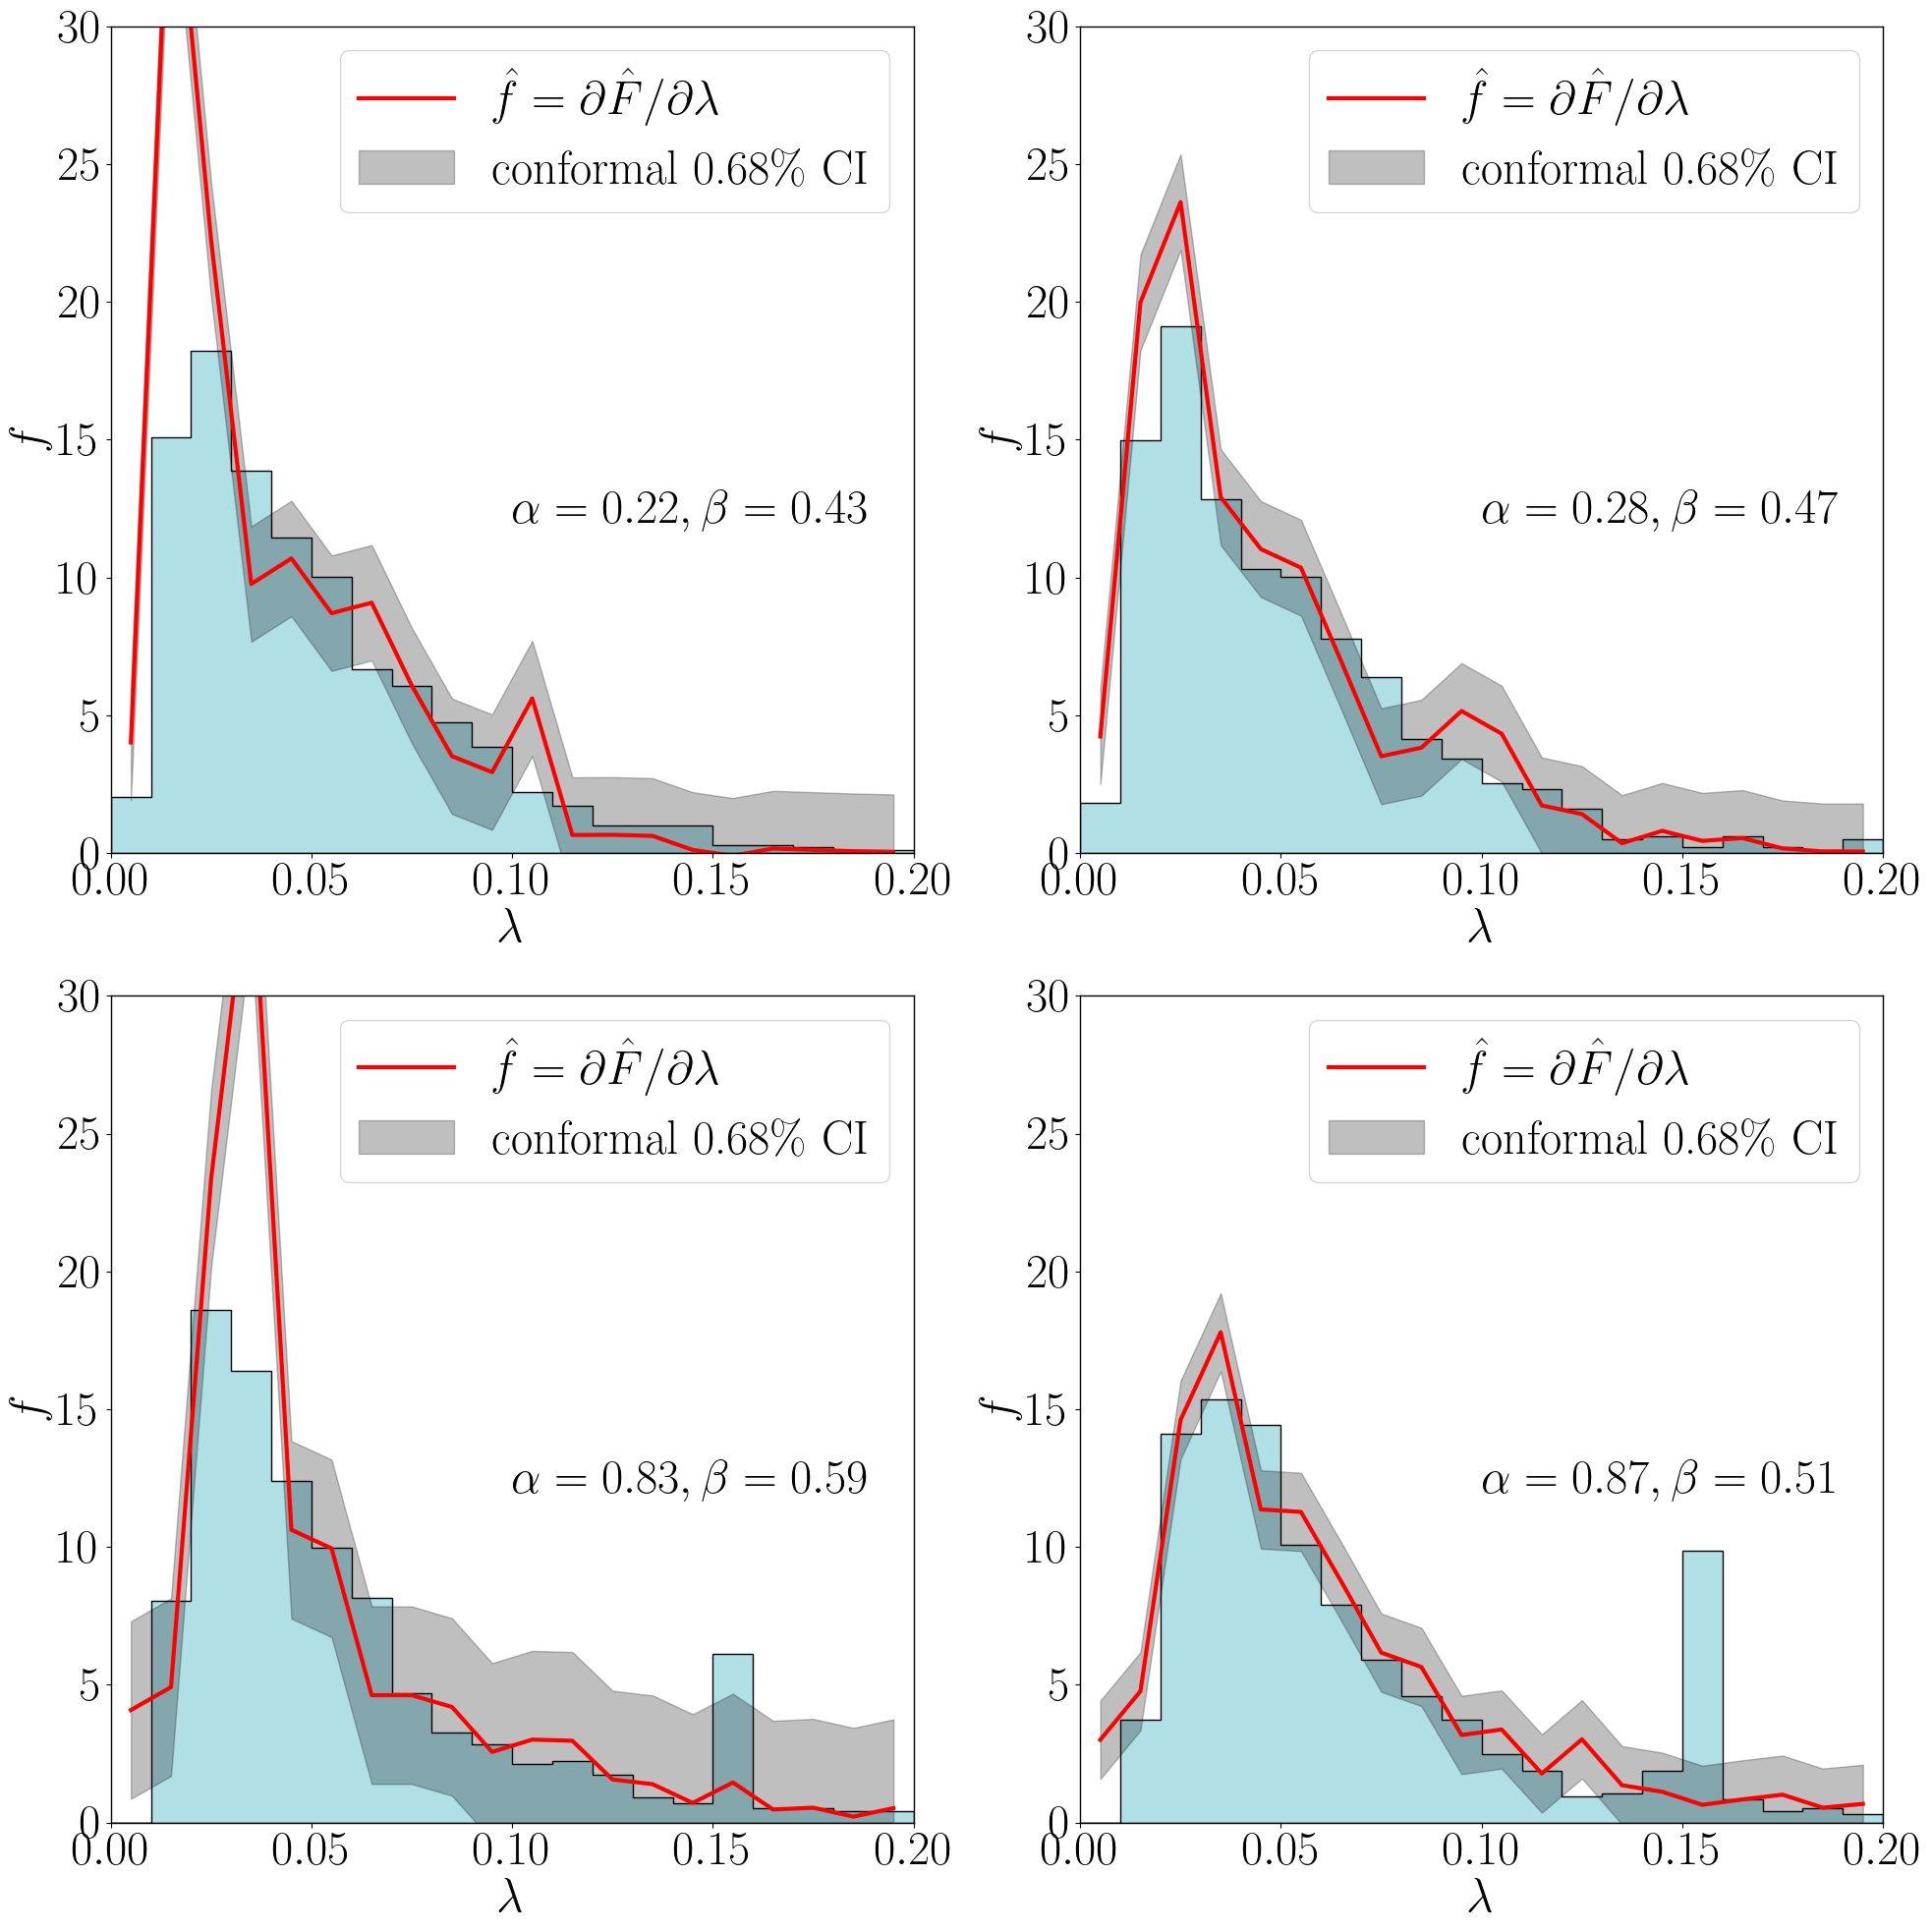

In [153]:
plot_PDFs(nrows=2, ncols=2, model=SIR_Tuned_Model_AQL, title='MLP with Huber Loss')